# Build Sentinel-3 Data Cubes

This notebook demonstrates how to construct 3D data cubes from multiple Sentinel-3 tiles using [**xcube-eopf**](https://github.com/EOPF-Sample-Service/xcube-eopf). The following steps are performed by **xcube-eopf** to generate the data cubes:

- **Query tiles**: Identify relevant Sentinel-3 tiles based on a spatiotemporal search using the [EOPF Zarr Sample Service STAC API](https://stac.core.eopf.eodc.eu).
- **Group by date**: Organize STAC items by solar day.
- **Grid rectification**: Convert Sentinel-3 data from its native 2D irregular grid to a regular grid using [xcube-resampling](https://xcube-dev.github.io/xcube-resampling/guide/#3-rectification), enabling adjacent tiles to be mosaicked.
- **Spatial mosaicking**: Merge adjacent tiles acquired on the same day into seamless scenes.
- **Time stacking**: Combine daily mosaics along the time dimension to form 3D data cubes for each data variable (e.g., spectral bands).

The following Sentinel-3 products are supported: 

- [Sentinel-3 OLCI Level-1 EFR](https://stac.browser.user.eopf.eodc.eu/collections/sentinel-3-olci-l1-efr)
- [Sentinel-3 OLCI Level-2 LFR](https://stac.browser.user.eopf.eodc.eu/collections/sentinel-3-olci-l2-lfr)
- [Sentinel-3 SLSTR Level-2 LST](https://stac.browser.user.eopf.eodc.eu/collections/sentinel-3-slstr-l2-lst)


In [1]:
from xcube.core.store import new_data_store
from xcube_resampling.utils import reproject_bbox
import xarray as xr

In [2]:
xr.set_options(display_expand_attrs=False)

To initialize an `eopf-zarr` [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework), execute the cell below:

In [3]:
store = new_data_store("eopf-zarr")

The data IDs point to [STAC collections](https://stac.browser.user.eopf.eodc.eu). In the following cell we can list the available data IDs.

In [4]:
store.list_data_ids()

['sentinel-2-l1c',
 'sentinel-2-l2a',
 'sentinel-3-olci-l1-efr',
 'sentinel-3-olci-l2-lfr',
 'sentinel-3-slstr-l1-rbt',
 'sentinel-3-slstr-l2-lst']

Below, the parameters for the `open_data` method can be viewed for each supported data product.

In [5]:
store.get_open_data_params_schema()

This function also shows opening parameters for a specific `data_id`, as shown below. 

In [6]:
store.get_open_data_params_schema(data_id="sentinel-3-olci-l1-efr")

We now want to generate a data cube from the Sentinel-3 OLCI Level-1 EFR product. We therefore assign `data_id` to `"sentinel-3-olci-l1-efr"`. We set the bounding box to cover the greater Hamburg area and the time range to Mai 2025.

In [7]:
bbox = [9.0, 53.0, 11.0, 54.0]
crs = "EPSG:4326"
time_range = ["2025-06-01", "2025-06-05"]
resolution = 300  # meter
bands = ["oa04_radiance", "oa06_radiance", "oa08_radiance"]  # RGB bands
interp_method = "nearest"
agg_method = "center"

In [8]:
%%time
ds = store.open_data(
    data_id="sentinel-3-olci-l1-efr",
    bbox=bbox,
    time_range=time_range,
    spatial_res=resolution / 111320,  # conversion to degree approx.
    crs=crs,
    variables=bands,
    interp_methods=interp_method,
    agg_methods=agg_method,
)
ds

CPU times: user 20.4 s, sys: 5.1 s, total: 25.5 s
Wall time: 2min 21s


<xarray.Dataset> Size: 13MB
Dimensions:        (time: 4, lat: 372, lon: 743)
Coordinates:
    spatial_ref    int64 8B 0
  * lon            (lon) float64 6kB 9.001 9.004 9.007 9.009 ... 11.0 11.0 11.0
  * lat            (lat) float64 3kB 54.0 54.0 54.0 53.99 ... 53.01 53.0 53.0
  * time           (time) datetime64[ns] 32B 2025-06-02T09:59:04.237228 ... 2...
Data variables:
    oa04_radiance  (time, lat, lon) float32 4MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
    oa06_radiance  (time, lat, lon) float32 4MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
    oa08_radiance  (time, lat, lon) float32 4MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
Attributes: (14)

CPU times: user 418 ms, sys: 93.1 ms, total: 511 ms
Wall time: 1.48 s


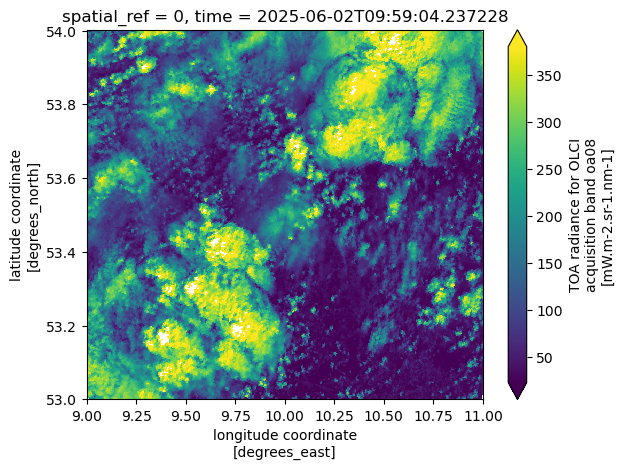

In [9]:
%%time
ds.oa08_radiance.isel(time=0).plot(robust=True)

Now we can request the same data cube but in a different CRS, e.g. in UTM. xcube-eopf can reproject the datacube to any projection requested by the user.

In [10]:
%%time
crs_utm = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_utm)
ds = store.open_data(
    data_id="sentinel-3-olci-l1-efr",
    bbox=bbox_utm,
    time_range=time_range,
    spatial_res=resolution,
    crs=crs_utm,
    variables=bands,
    interp_methods=interp_method,
    agg_methods=agg_method,
)
ds

CPU times: user 35 s, sys: 4.9 s, total: 39.8 s
Wall time: 2min 33s


<xarray.Dataset> Size: 8MB
Dimensions:        (time: 4, y: 378, x: 448)
Coordinates:
    spatial_ref    int64 8B 0
  * x              (x) float64 4kB 5.002e+05 5.004e+05 ... 6.34e+05 6.342e+05
  * y              (y) float64 3kB 5.986e+06 5.985e+06 ... 5.873e+06 5.872e+06
  * time           (time) datetime64[ns] 32B 2025-06-02T09:59:04.237228 ... 2...
Data variables:
    oa04_radiance  (time, y, x) float32 3MB dask.array<chunksize=(1, 378, 448), meta=np.ndarray>
    oa06_radiance  (time, y, x) float32 3MB dask.array<chunksize=(1, 378, 448), meta=np.ndarray>
    oa08_radiance  (time, y, x) float32 3MB dask.array<chunksize=(1, 378, 448), meta=np.ndarray>
Attributes: (14)

CPU times: user 357 ms, sys: 88.2 ms, total: 445 ms
Wall time: 1.32 s


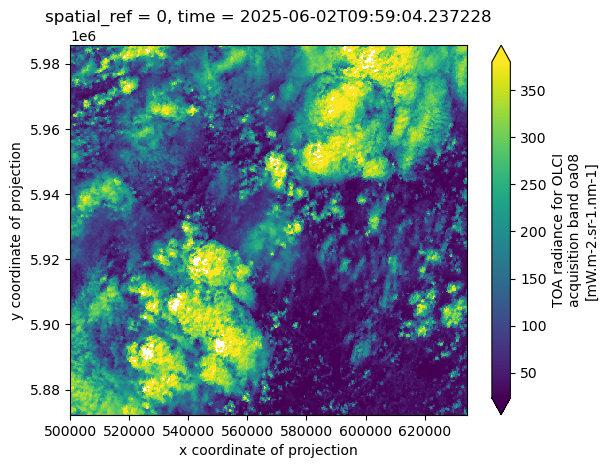

In [11]:
%%time
ds.oa08_radiance.isel(time=0).plot(robust=True)

We now want to generate a similar data cube from the Sentinel-3 OLCI Level-2 LFR product. We therefore assign `data_id` to `"sentinel-3-olci-l2-lfr"`.

In [12]:
%%time
ds = store.open_data(
    data_id="sentinel-3-olci-l2-lfr",
    bbox=bbox,
    time_range=time_range,
    spatial_res=resolution / 111320,  # conversion to degree approx.
    crs=crs,
    interp_methods=interp_method,
    agg_methods=agg_method,
)
ds

CPU times: user 22.7 s, sys: 6.14 s, total: 28.8 s
Wall time: 2min 44s


<xarray.Dataset> Size: 28MB
Dimensions:      (time: 5, lat: 372, lon: 743)
Coordinates:
    spatial_ref  int64 8B 0
  * lon          (lon) float64 6kB 9.001 9.004 9.007 9.009 ... 11.0 11.0 11.0
  * lat          (lat) float64 3kB 54.0 54.0 54.0 53.99 ... 53.01 53.0 53.0
  * time         (time) datetime64[ns] 40B 2025-06-01T10:25:15.241840 ... 202...
Data variables:
    gifapar      (time, lat, lon) float32 6MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
    iwv          (time, lat, lon) float32 6MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
    otci         (time, lat, lon) float32 6MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
    rc681        (time, lat, lon) float32 6MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
    rc865        (time, lat, lon) float32 6MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
Attributes: (15)

CPU times: user 100 ms, sys: 14.2 ms, total: 114 ms
Wall time: 293 ms


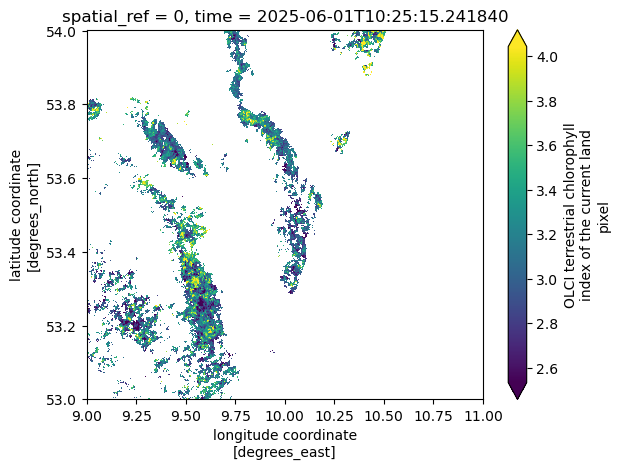

In [13]:
%%time
ds.otci.isel(time=0).plot(robust=True)

Next, we want to generate a similar data cube from the Sentinel-3 SLSTR Level-2 LST product. We therefore assign `data_id` to `"sentinel-3-slstr-l2-lst"`.

In [14]:
%%time
ds = store.open_data(
    data_id="sentinel-3-slstr-l2-lst",
    bbox=bbox,
    time_range=time_range,
    spatial_res=resolution / 111320,  # conversion to degree approx.
    crs=crs,
    interp_methods=interp_method,
    agg_methods=agg_method,
)
ds

CPU times: user 2min 4s, sys: 3.38 s, total: 2min 7s
Wall time: 3min 23s


<xarray.Dataset> Size: 17MB
Dimensions:      (time: 5, lat: 372, lon: 743)
Coordinates:
    spatial_ref  int64 8B 0
  * lon          (lon) float64 6kB 9.001 9.004 9.007 9.009 ... 11.0 11.0 11.0
  * lat          (lat) float64 3kB 54.0 54.0 54.0 53.99 ... 53.01 53.0 53.0
  * time         (time) datetime64[ns] 40B 2025-06-01T21:12:21.773332 ... 202...
Data variables:
    lst          (time, lat, lon) float32 6MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
    elevation    (time, lat, lon) float64 11MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
Attributes: (21)

CPU times: user 218 ms, sys: 76.4 ms, total: 295 ms
Wall time: 1.25 s


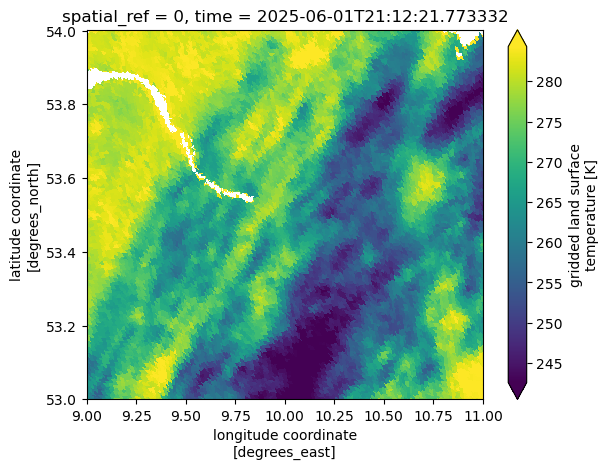

In [15]:
%%time
ds.lst.isel(time=0).plot(robust=True)

Lastly, we want to generate a similar data cube from the Sentinel-3 SLSTR Level-1 RBT product. We therefore assign `data_id` to `"sentinel-3-slstr-l1-rbt"`.

In [16]:
%%time
ds = store.open_data(
    data_id="sentinel-3-slstr-l1-rbt",
    bbox=bbox,
    time_range=time_range,
    spatial_res=resolution / 111320,  # conversion to degree approx.
    crs=crs,
    variables=["s1_radiance_an", "s1_radiance_ao"],
    interp_methods=interp_method,
    agg_methods=agg_method,
)
ds

CPU times: user 9min 56s, sys: 1min, total: 10min 56s
Wall time: 26min 19s


<xarray.Dataset> Size: 22MB
Dimensions:         (time: 5, lat: 372, lon: 743)
Coordinates:
    spatial_ref     int64 8B 0
  * lon             (lon) float64 6kB 9.001 9.004 9.007 9.009 ... 11.0 11.0 11.0
  * lat             (lat) float64 3kB 54.0 54.0 54.0 53.99 ... 53.01 53.0 53.0
  * time            (time) datetime64[ns] 40B 2025-06-01T21:12:21.773332 ... ...
Data variables:
    s1_radiance_an  (time, lat, lon) float64 11MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
    s1_radiance_ao  (time, lat, lon) float64 11MB dask.array<chunksize=(1, 372, 743), meta=np.ndarray>
Attributes: (95)

CPU times: user 367 ms, sys: 89.8 ms, total: 457 ms
Wall time: 2.78 s


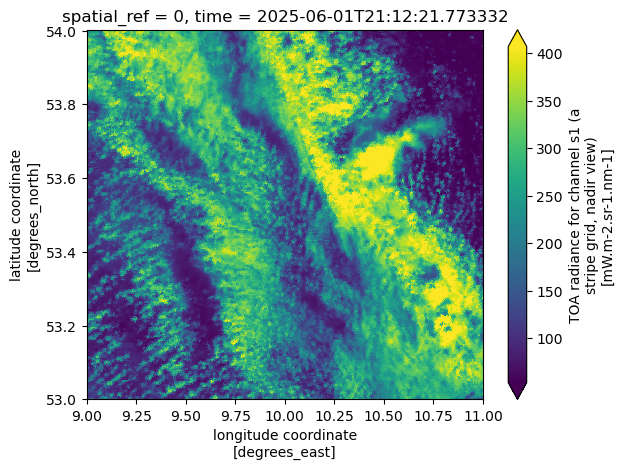

In [19]:
%%time
ds.s1_radiance_an.isel(time=0).plot(robust=True)

CPU times: user 218 ms, sys: 38.5 ms, total: 256 ms
Wall time: 1.12 s


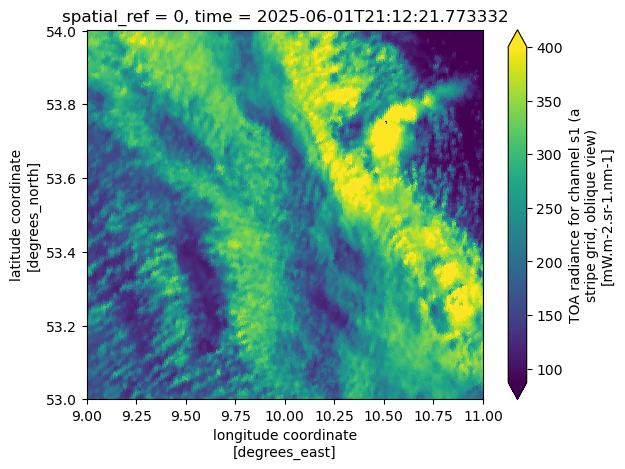

In [20]:
%%time
ds.s1_radiance_ao.isel(time=0).plot(robust=True)